In [1]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
from tqdm import tqdm
%matplotlib inline

In [2]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'

t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

columns = ['gamma_prediction_mean', 'gamma_energy_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy', 'num_triggered_telescopes']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gammas = gammas.dropna()
gammas['type'] = 0
gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 1
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)

crab = CrabSpectrum()
cosmic_proton = CosmicRaySpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

print(gammas.columns)

print(len(protons))
print(len(gammas))

Index(['gamma_prediction_mean', 'gamma_energy_prediction_mean',
       'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy',
       'num_triggered_telescopes', 'type', 'weight'],
      dtype='object')
7304127
959909


In [3]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

gammas['theta'] = calculate_theta(gammas)
protons['theta'] = calculate_theta(protons)

In [27]:
def count_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum(), m.sum()


def count_off_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    region = 1
    df = df.query(f'theta < {region}')
    m = df.gamma_prediction_mean >= prediction_threshold
    alpha = theta2/region**2
    return df[m].weight.sum(), m.sum(), alpha


def select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=False):
    
    column = 'mc_energy' if use_true_energy else 'gamma_energy_prediction_mean'
    m = ((signal[column] > e_low ) & (signal[column] < e_high ))
    s = signal[m]

    m = ((background[column] > e_low ) & (background[column] < e_high ))
    b = background[m]
    return s, b

def scaling_factor(n_signal, n_background, t_signal, t_background, alpha, N=200): 
    
    right_bound = 100

    def target(scaling_factor, n_signal, n_background, sigma=5):
        n_on = n_background*alpha + n_signal * scaling_factor
        n_off = n_background
        
        significance = li_ma_significance(n_on, n_off, alpha=alpha)
        return (5 - significance)**2
    
#     print(t_background, n_background, '---------', t_signal, n_signal)
    n_signal = np.random.poisson(t_signal, size=N) * n_signal / t_signal
    n_background = np.random.poisson(t_background, size=N) * n_background / t_background
    
    
    hs = []
    for signal, background in zip(n_signal, n_background):
        if background == 0:
            hs.append(np.nan)
        else:
            result = minimize_scalar(target, args=(signal, background), bounds=(0, right_bound), method='bounded').x
            if np.allclose(result, right_bound):
                result = np.nan
            hs.append(result)
    return np.nanpercentile(np.array(hs), (50, 5, 95))


# regions=slice(0.015, 0.02, 0.0025), thresholds=slice(0.8, 9, 0.05)
#regions=slice(0.0025, 0.07, 0.0025), thresholds=slice(0.3, 1, 0.05)
def find_best_cuts(signal, background, regions=slice(0.0025, 0.08, 0.01), thresholds=slice(0.4, 1, 0.05), method='simple'):
    
    def significance_target(cuts, signal, background):
        theta2, p_cut = cuts
        n_signal, t_signal = count_events_in_region(signal, theta2=theta2, prediction_threshold=p_cut)

        if method == 'exact':
            n_background, t_background = count_events_in_region(background, theta2=theta2, prediction_threshold=p_cut)
            alpha=1
        elif method == 'simple':
            n_background, t_background, alpha = count_off_events_in_region(background, theta2=theta2, prediction_threshold=p_cut)

        if t_signal <= t_background*alpha  + 10:
#             print('signal not large enough')
            return 0
        
        if n_signal*5 < n_background*alpha * 0.01:
#             print('sys problem')
            return 0
            
                
        n_on = n_signal + n_background*alpha
        n_off = n_background
        return -li_ma_significance(n_on, n_off, alpha=alpha)

    result = brute(significance_target, ranges=[regions, thresholds], args=(signal, background), finish=None)
    print(result)
    return result


def calc_relative_sensitivity(signal, background, bin_edges, use_true_energy=False, method='simple'):
    relative_sensitivities = []

    for e_low, e_high in tqdm(zip(bin_edges[:-1], bin_edges[1:])):
        s, b = select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=use_true_energy)
        
        theta2, cut = find_best_cuts(s, b, method=method)

        n_signal, t_signal = count_events_in_region(s, theta2=theta2, prediction_threshold=cut)

        if method == 'simple':
            n_background, t_background, alpha = count_off_events_in_region(b, theta2=theta2, prediction_threshold=cut)
        elif method == 'exact':
            n_background, t_background = count_events_in_region(b, theta2=theta2, prediction_threshold=cut)
            alpha=1
       
        print(n_background, t_background, alpha)
        n_on = n_background*alpha + n_signal
        n_off = n_background
        print(li_ma_significance(n_on, n_off, alpha))
        rs = scaling_factor(n_signal, n_background, t_signal, t_background, alpha)
        relative_sensitivities.append(rs)
        
       
        
    m, l, h = np.array(relative_sensitivities).T
    d = {'sensitivity': m, 'sensitivity_low': l, 'sensitivity_high': h}
    return pd.DataFrame(d)



In [28]:
def plot_sensitivity(rs, crab, bin_edges, bin_center, color='blue', **kwargs):
    sensitivity = rs.sensitivity.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_low = rs.sensitivity_low.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_high = rs.sensitivity_high.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    yerr = [np.abs(sensitivity - sensitivity_low).value, np.abs(sensitivity - sensitivity_high).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, yerr=yerr, linestyle='', ecolor=color, **kwargs)

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(bin_edges, crab.flux(bin_edges) * bin_edges**2, '--', color='gray')
    plt.ylim([1E-14, 1E-9])
    
    path = '../resources/ascii/CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python')
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg/(u.cm**2 * u.s)

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='black',)

    
    path = '../resources/sensitivity_requirement_south_50.txt'
    df = pd.read_csv(path, delim_whitespace=True, names=['log_energy', 'sensitivity'], index_col=False,  engine='python')
    df['energy'] = 10**df.log_energy
    plt.plot(df.energy, df.sensitivity, color='gray')
    
    plt.plot(df.energy, df.sensitivity * 3, color='lightgray', linestyle='--')
    
    plt.ylabel(r'$ E^2 \cdot \mathrm{photons} \quad \mathrm{erg} /( \mathrm{s} \quad  \mathrm{cm}^2$ )  in ' + str(t_obs.to('h')) )
    plt.xlabel(r'$E /  \mathrm{TeV}$')


In [29]:
rs_simple = calc_relative_sensitivity(gammas, protons, bin_edges, method='simple')
rs_exact = calc_relative_sensitivity(gammas, protons, bin_edges, method='exact')

s = gammas.query('num_triggered_telescopes >= 4')
b = protons.query('num_triggered_telescopes >= 4')
rs_mult = calc_relative_sensitivity(s, b, bin_edges, method='simple')

0it [00:00, ?it/s]

[0.0625 0.9   ]
39350269.7078944 19682 0.0625
346.41631861890266


1it [00:01,  1.82s/it]

[0.0425 0.9   ]
7944516.280765319 4852 0.0425
339.8420845881094


2it [00:03,  1.66s/it]

[0.0325 0.85  ]
11581770.674139332 8759 0.0325
455.91421712503114


3it [00:05,  1.78s/it]

[0.0225 0.85  ]
5431684.712716152 5087 0.0225
560.2334343920257


4it [00:07,  1.98s/it]

[0.0225 0.85  ]
1264883.9953998828 1448 0.0225
625.1700071696573


5it [00:10,  2.04s/it]

[0.0125 0.85  ]
252967.10183546686 353 0.0125
598.0546346464705


6it [00:11,  1.99s/it]

[0.0125 0.85  ]
322904.6992840021 595 0.0125
577.7346507357366


7it [00:13,  1.97s/it]

[0.0125 0.8   ]
472031.0423189703 1248 0.0125
459.5996058609674


8it [00:15,  1.94s/it]

[0.0125 0.8   ]
361375.8220869632 1186 0.0125
367.32132186861276


9it [00:17,  1.91s/it]

[0.0125 0.75  ]
212554.13609277396 857 0.0125
312.17231159163845


10it [00:18,  1.85s/it]

[0.0125 0.75  ]
73646.02359958026 388 0.0125
268.9565711902876


11it [00:19,  1.79s/it]

[0.0125 0.75  ]
26002.684712195747 181 0.0125
202.96349331895337


12it [00:20,  1.74s/it]

[0.0025 0.75  ]
10569.926314835879 105 0.0025
157.84717950322826


13it [00:21,  1.69s/it]

[0.0025 0.75  ]
4855.351367569117 63 0.0025
123.64400734179698


14it [00:22,  1.64s/it]

[0.0025 0.75  ]
1191.557569707647 26 0.0025
93.65616956818467


15it [00:24,  1.60s/it]

[0.0025 0.75  ]
602.4088923879441 21 0.0025
64.02128607204068


16it [00:25,  1.56s/it]

[0.0025 0.75  ]
119.12210269187916 7 0.0025
48.324117985186724


17it [00:25,  1.52s/it]

[0.0025 0.7   ]
35.570434422140536 3 0.0025
35.54005604022947


18it [00:26,  1.48s/it]

[0.0025 0.75  ]
13.582218544993085 1 0.0025
22.930489623222687


19it [00:27,  1.43s/it]

[0.0025 0.75  ]
26.176235218992048 3 0.0025
12.414809882510372


20it [00:27,  1.40s/it]
0it [00:00, ?it/s]

[0.0625 0.9   ]
2298063.572455613 1137 1
256.1147804708156


1it [00:01,  1.11s/it]

[0.0425 0.9   ]
359937.14589381986 217 1
229.63985401098282


2it [00:02,  1.17s/it]

[0.0325 0.8   ]
615372.9707656603 484 1
299.7160784949832


3it [00:03,  1.31s/it]

[0.0325 0.85  ]
170207.4955526105 162 1
368.7069329444128


4it [00:06,  1.62s/it]

[0.0225 0.85  ]
32193.990048558364 34 1
362.99772017046996


5it [00:08,  1.78s/it]

[0.0325 0.8   ]
19805.148038693456 29 1
325.69258727639914


6it [00:10,  1.79s/it]

[0.0325 0.75  ]
37288.218569802586 68 1
315.33307723673073


7it [00:12,  1.80s/it]

[0.0225 0.8   ]
10472.841896994276 29 1
262.1072046230377


8it [00:14,  1.80s/it]

[0.0225 0.75  ]
8009.302331894056 30 1
220.36388158095917


9it [00:15,  1.77s/it]

[0.0125 0.65  ]
3753.2049587338515 17 1
173.3883281700213


10it [00:17,  1.74s/it]

[0.0125 0.65  ]
825.4031267335033 6 1
149.5185146064344


11it [00:18,  1.71s/it]

[0.0225 0.75  ]
371.7404823701604 3 1
104.7074024548287


12it [00:20,  1.68s/it]

[0.0125 0.6   ]
344.06965689787387 4 1
75.59095495454432


13it [00:21,  1.65s/it]

[0.0125 0.65  ]
60.67261772679084 1 1
58.58503477678483


14it [00:22,  1.62s/it]

[0.0425 0.75  ]
18.62447440162494 1 1
40.03566629765025


15it [00:23,  1.58s/it]

[0.0225 0.55  ]
43.426168910339555 2 1
27.0947402690638


16it [00:24,  1.55s/it]

[0.0725 0.7   ]
6.6259288738614455 1 1
19.154284101341833


17it [00:25,  1.50s/it]

[0.0125 0.4   ]
12.900014866056054 1 1
12.416237108768355


19it [00:26,  1.41s/it]

[0.0725 0.45  ]
13.350659840313847 1 1
6.982559506866396


20it [00:27,  1.37s/it]

[0.0425 0.4   ]
5.059702032633296 1 1
3.806477107069568



0it [00:00, ?it/s]

[0.0525 0.9   ]
7813943.315556491 4135 0.052500000000000005
268.08025984717887


1it [00:01,  1.16s/it]

[0.0325 0.9   ]
5893873.596755961 3651 0.0325
321.27370448502234


2it [00:02,  1.13s/it]

[0.0325 0.9   ]
5370377.746044929 3954 0.0325
455.03260520282464


3it [00:03,  1.14s/it]

[0.0225 0.9   ]
2172881.844532265 1963 0.0225
556.1219589475251


4it [00:04,  1.20s/it]

[0.0125 0.9   ]
419259.11857284256 466 0.0125
621.7871277253254


5it [00:06,  1.25s/it]

[0.0125 0.85  ]
145153.98607805304 204 0.0125
591.7936010291224


6it [00:07,  1.30s/it]

[0.0125 0.8   ]
141772.29030322685 248 0.0125
624.7027057258742


7it [00:09,  1.31s/it]

[0.0125 0.8   ]
53813.72210996694 131 0.0125
505.4845906304129


8it [00:10,  1.34s/it]

[0.0125 0.8   ]
24695.352755390602 88 0.0125
419.72288787581806


9it [00:11,  1.32s/it]

[0.0125 0.75  ]
26426.667998721845 132 0.0125
351.9866217645368


10it [00:13,  1.32s/it]

[0.0125 0.75  ]
12189.15701665166 79 0.0125
297.38509126450833


11it [00:14,  1.33s/it]

[0.0025 0.75  ]
6281.4390847216355 55 0.0025
218.824532772566


12it [00:15,  1.31s/it]

[0.0025 0.75  ]
3337.176510668272 41 0.0025
166.47668962184903


13it [00:16,  1.28s/it]

[0.0025 0.8   ]
676.7130998461646 12 0.0025
130.3149421394499


14it [00:17,  1.26s/it]

[0.0025 0.75  ]
386.1657297970795 9 0.0025
98.0233539937924


15it [00:18,  1.23s/it]

[0.0025 0.75  ]
159.67327876326254 6 0.0025
68.32391828341903


16it [00:19,  1.21s/it]

[0.0025 0.75  ]
61.462115087099036 4 0.0025
49.321043402074224


17it [00:20,  1.19s/it]

[0.0025 0.7   ]
30.750039460545253 2 0.0025
35.58329753427698


18it [00:21,  1.17s/it]

[0.0025 0.75  ]
13.582218544993085 1 0.0025
22.930489623222687


19it [00:21,  1.14s/it]

[0.0025 0.75  ]
26.176235218992048 3 0.0025
12.414809882510372


20it [00:22,  1.12s/it]


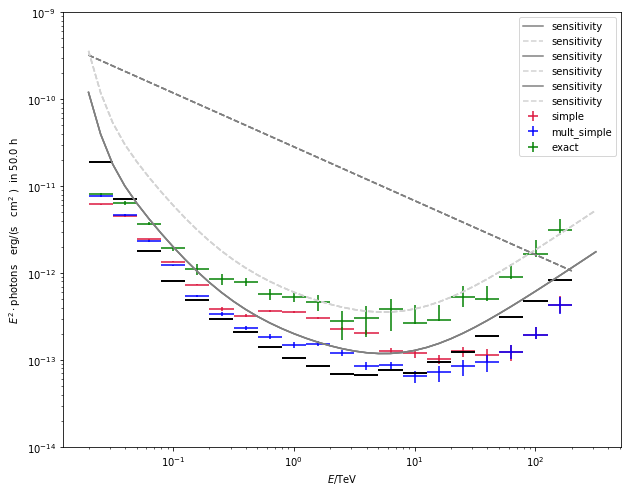

In [30]:
plt.figure(figsize=(10, 8))

# plot_sensitivity(rs_smooth, crab, bin_edges, bin_center, color='blue')

plot_sensitivity(rs_simple, crab, bin_edges, bin_center, color='crimson', label='simple')
plot_sensitivity(rs_mult, crab, bin_edges, bin_center, color='blue', label='mult_simple')
plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='green', label='exact')
plt.legend()

# plot_sensitivity(rs_simple_02, crab, bin_edges, bin_center, color='blue')


# plot_sensitivity(rs_smooth_02, crab, bin_edges, bin_center, color='navy')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(protons.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax1.hist(protons.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Protons')
ax1.set_xlabel('Energy / TeV')

ax2.hist(gammas.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax2.hist(gammas.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Gammas')
ax2.set_xlabel('Energy / TeV')